# Bayesian Optimization of CNN with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package 

## Notebook content

- Data Preparation
- Set up a simple CNN
- Set up the hyperparameter search shape
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [4]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


Text(0, 0.5, 'Number of images')

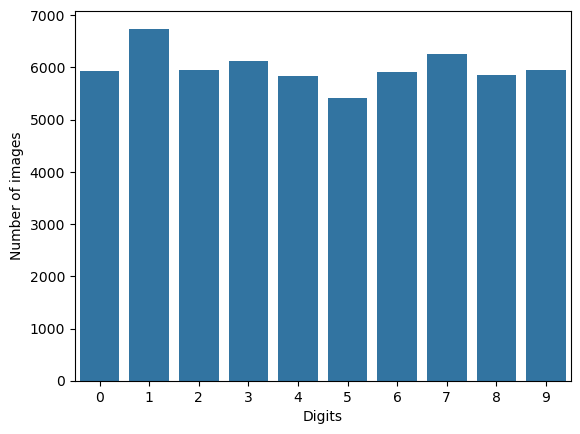

In [6]:
g = sns.countplot(x = y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

In [7]:
X_train = X_train / 255
X_test = X_test / 255


## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [10]:
#Target encoder 
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)


In [12]:
#Define the cnn
def create_cnn(
        learning_rate,
        num_dense_layers,
        num_dense_nodes,
        activation,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    model = Sequential()


    model.add(Conv2D(filters = 16, padding = 'same',kernel_size = 5, strides =1,
                     activation = activation, input_shape = (28, 28, 1),
                     name = 'layer_conv1'))
    
    model.add(MaxPool2D(pool_size=2, strides = 2))

    #Second conv layer
    model.add(Conv2D(filters = 36, padding = 'same',kernel_size = 5, strides =1,
                     activation = activation, input_shape = (28, 28, 1),
                     name = 'layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides = 2))

    model.add(Flatten())

    for i in range(num_dense_layers):
        model.add(Dense(num_dense_layers,
                        activation))
        
    model.add(Dense(10, activation = 'softmax'))
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [13]:
# Define the hyperparemeters space
dim_learning_rate = Real(
    low = 1e-6, high = 1e-2, prior = 'log-uniform', name = 'learning_rate',
    
)

dim_num_dense_layers = Integer(low = 1, high = 5, name = 'num_dense_layers')
dim_num_dense_nodes = Integer(low =5, high = 512, name = 'num_dense_nodes')
dim_activation = Categorical(categories = ['relu','sigmoid'], name = 'activation')

In [14]:
#The hyperspace space grid
param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation
]

In [15]:
## Define the objective function
path_best_model = 'cnn_model.keras'
best_accuracy = 0